In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import MaxAbsScaler

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

In [2]:


# Load the dataset file
dataset = pd.read_pickle('SNR_BBH-injections-reduced-1m.pkl')

dataset = dataset.loc[dataset["SNR"] <= 100]

TargetVariable = ['SNR']
Predictors = ['Mc', 'q', 'inc', 'ra' , 'dec' , 'spin1_mag', 'spin1_polar', 'spin1_azimuthal', 'spin2_mag', 'spin2_polar', 'spin2_azimuthal']


X = dataset[Predictors].values
y = dataset[TargetVariable].values


# Sandardization of data #
PredictorScaler = StandardScaler()
Xscaled = PredictorScaler.fit_transform(X)


TargetScaler =  StandardScaler()
yscaled = TargetScaler.fit_transform(y)


# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xscaled, yscaled, test_size=0.3, random_state=42)
 

In [3]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (699997, 11)
y_train shape: (699997, 1)


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, PReLU, MaxPooling1D, Flatten, Dense, SimpleRNN, Reshape

model = Sequential()

# Add SimpleRNN layer
model.add(SimpleRNN(200, input_shape=(11, 1), return_sequences=True))

# 1 Conv1D layer with PReLU activation
model.add(Conv1D(filters=42, kernel_size=7, padding='same'))
model.add(PReLU())

# 2 Conv1D layer with PReLU activation
model.add(Conv1D(filters=81, kernel_size=7, padding='same'))
model.add(PReLU())

# 3 Conv1D layer with PReLU activation
model.add(Conv1D(filters=110, kernel_size=5, padding='same'))
model.add(PReLU())

# 4 Conv1D layer with PReLU activation
model.add(Conv1D(filters=200, kernel_size=3, padding='same'))
model.add(PReLU())

# 5 Conv1D layer with PReLU activation
model.add(Conv1D(filters=300, kernel_size=2, padding='same'))
model.add(PReLU())

# 6 Conv1D layer with PReLU activation
model.add(Conv1D(filters=400, kernel_size=1, padding='same'))
model.add(PReLU())

# Pooling layer
model.add(MaxPooling1D(pool_size=2))

# 7 Conv1D layer with PReLU activation
model.add(Conv1D(filters=300, kernel_size=2, padding='same'))
model.add(PReLU())

# Add second SimpleRNN layer
model.add(SimpleRNN(128, return_sequences=True))

# Flatten layer
model.add(Flatten())

# Dense layer with PReLU activation
model.add(Dense(100))
model.add(PReLU())

# Output layer
model.add(Dense(1))






# Compile the model
model.compile(loss='mse', optimizer='Nadam')



batch_size = 500 
epochs = 295 



# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, validation_split=0.33, batch_size = batch_size, epochs = epochs, verbose=1)


Epoch 1/295
938/938 [==============================] - 20s 18ms/step - loss: 0.1872 - val_loss: 0.0679
Epoch 2/295
938/938 [==============================] - 18s 19ms/step - loss: 0.0705 - val_loss: 0.0467
Epoch 3/295
938/938 [==============================] - 18s 20ms/step - loss: 0.0483 - val_loss: 0.0456
Epoch 4/295
938/938 [==============================] - 18s 19ms/step - loss: 0.0387 - val_loss: 0.0456
Epoch 5/295
938/938 [==============================] - 18s 19ms/step - loss: 0.0323 - val_loss: 0.0255
Epoch 6/295
938/938 [==============================] - 17s 19ms/step - loss: 0.0282 - val_loss: 0.0227
Epoch 7/295
938/938 [==============================] - 17s 19ms/step - loss: 0.0233 - val_loss: 0.0189
Epoch 8/295
938/938 [==============================] - 17s 18ms/step - loss: 0.0193 - val_loss: 0.0212
Epoch 9/295
938/938 [==============================] - 18s 19ms/step - loss: 0.0165 - val_loss: 0.0177
Epoch 10/295
938/938 [==============================] - 18s 19ms/step - l

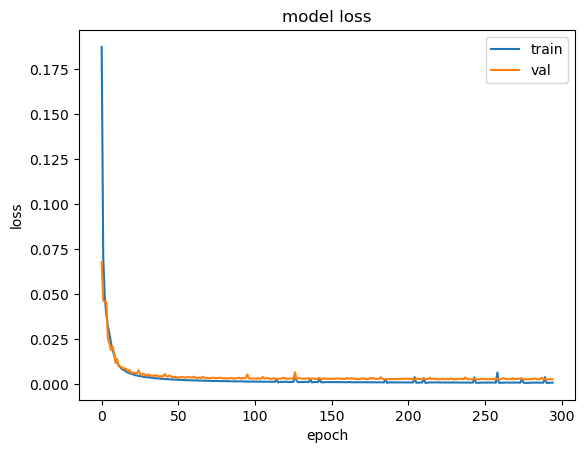

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig("Figure_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [46]:
# Generating Predictions on testing data
Predictions_scaled = model.predict(X_test)

# Scaling the test data back to original scale
Test_Data = PredictorScaler.inverse_transform(X_test)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetScaler.inverse_transform(y_test)

# Scaling the predicted Price data back to original price scale
Predictions = TargetScaler.inverse_transform(Predictions_scaled)

# Create table with test data and predictions
TestingData = pd.DataFrame( data = Test_Data, columns = Predictors)
TestingData['SNR'] = y_test_orig
TestingData['PredictedSNR'] = Predictions

# Computing the absolute percent error
APE = 100*(abs( (TestingData['SNR']-TestingData['PredictedSNR'])/TestingData['SNR']) )
TestingData['APE']=APE

# Computing the error
Error = TestingData['SNR']-TestingData['PredictedSNR']
TestingData['Error']=Error


TestingData.head()

9375/9375 [==============================] - 33s 4ms/step


,Mc,q,inc,ra,dec,spin1_mag,spin1_polar,spin1_azimuthal,spin2_mag,spin2_polar,spin2_azimuthal,SNR,PredictedSNR,APE,Error
0,13.629561,5.024858,0.759582,1.157298,0.546656,0.814804,0.191502,5.077727,0.877996,0.110203,5.707897,13.988222,13.713797,1.961833,0.274426
1,13.506763,1.873409,0.496980,2.336597,0.743398,0.444129,1.696529,5.894138,0.480214,1.640247,3.345891,14.263174,13.966695,2.078633,0.296479
2,16.706566,1.790420,2.224368,1.441924,0.536652,0.038654,1.737126,4.311931,0.670894,0.304500,0.771137,15.918194,16.139893,1.392739,-0.221699
3,31.103646,1.020864,2.009380,3.259870,0.432807,0.269319,0.198721,4.969034,0.881395,1.221976,3.256650,8.188298,8.359429,2.089954,-0.171132
4,22.591072,3.238326,1.340895,5.087919,-0.129831,0.563057,1.479941,3.217394,0.154200,2.685003,2.336052,6.937942,7.500992,8.115510,-0.563049


In [47]:
# Compute MAPE and accuracy

MAPE = np.mean(TestingData['APE'])
accuracy = 100 - MAPE

print('MAPE:', MAPE, 'accuracy:', accuracy)

MAPE: 2.9805011212500565 accuracy: 97.01949887874994


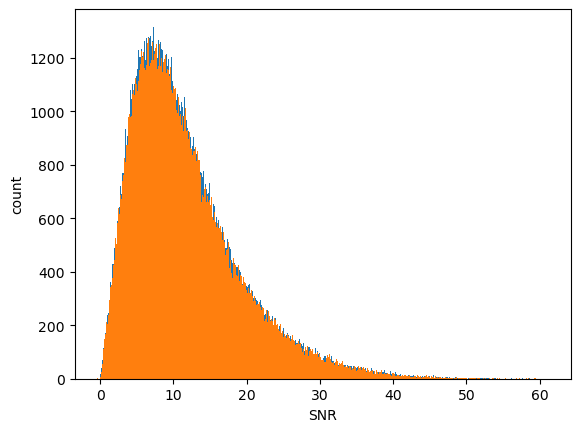

In [48]:
count, bins, ignored = plt.hist(y_test_orig, 1000)
count, bins, ignored = plt.hist(Predictions, 1000)
plt.xlabel('SNR')
plt.ylabel('count')

plt.savefig("Figure_SNR.pdf", format="pdf", bbox_inches="tight")
plt.show()

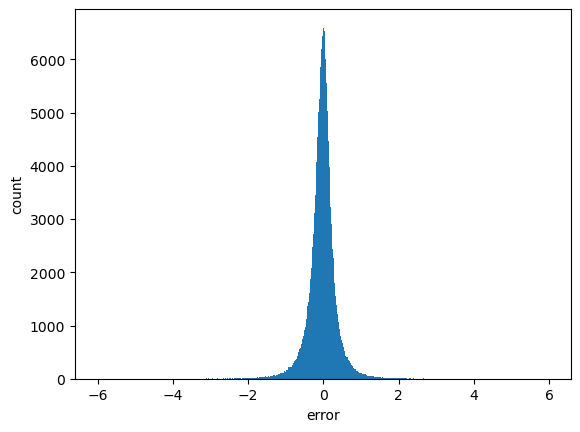

In [49]:
count, bins, ignored = plt.hist(TestingData['Error'], 1000)
#plt.xlim(-100,100)
plt.xlabel('error')
plt.ylabel('count')

plt.savefig("Figure_error.pdf", format="pdf", bbox_inches="tight")
plt.show()

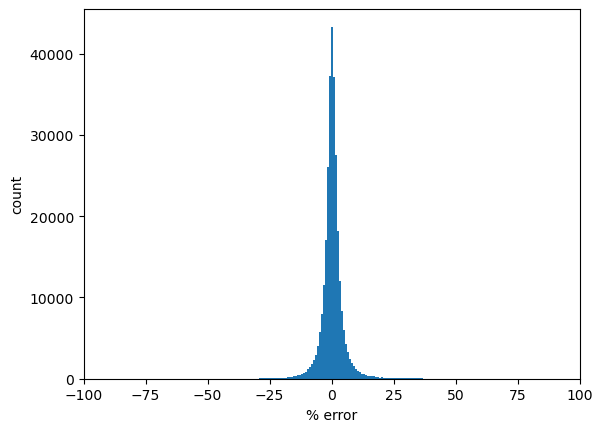

In [52]:
rel_error = 100*(Predictions - y_test_orig)/y_test_orig

count, bins, ignored = plt.hist(rel_error, 2000)
plt.xlabel('% error')
plt.ylabel('count')
plt.xlim(-100,100)

plt.show()

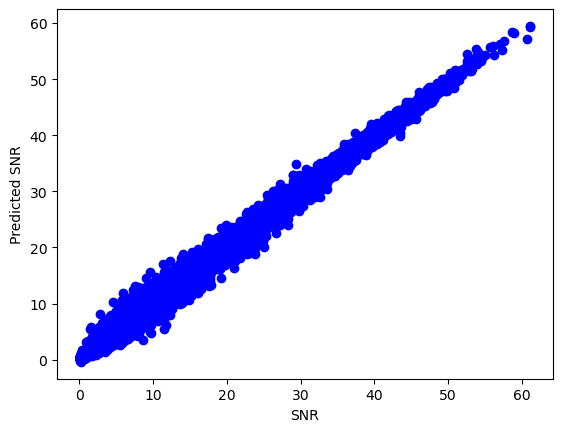

In [50]:
plt.plot(y_test_orig, Predictions, 'bo')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('SNR')
plt.ylabel('Predicted SNR')

plt.savefig("Figure_predicted.pdf", format="pdf", bbox_inches="tight")
plt.show()

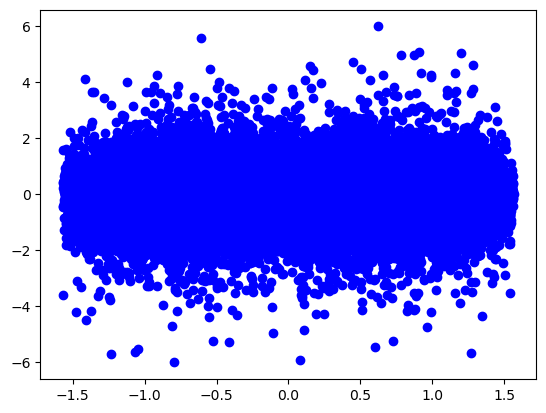

In [51]:
plt.plot(TestingData['dec'], TestingData['Error'], 'bo')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper right')
plt.show()